# `nbragg` tutorial
Tsviki Y. Hirsh, Andrew FT. Leong

Nov 11th 2024

This tutorial demonstrates the usage of nbragg to model and fit Bragg-Edges transmission spectrum of an iron powder.

The nbragg repo is located here: [https://github.com/TsvikiHirsh/nbragg](https://github.com/TsvikiHirsh/nbragg)

# Installation
Simply type

```bash
pip install git+https://github.com/TsvikiHirsh/nbragg.git
```

In [1]:
import nbragg

# Quick start

/sammy/work/Programs/braggedgemodeling/bem/peak_profile.py:88: RuntimeWarning: divide by zero encountered in divide
  y = (alpha*sigma2+x)/(sqrt2*sigma)
/sammy/work/Programs/braggedgemodeling/bem/peak_profile.py:89: RuntimeWarning: divide by zero encountered in divide
  z = (beta*sigma2 - x)/(sqrt2*sigma)


array([<Axes: ylabel='Transmission'>,
       <Axes: xlabel='λ [Å]', ylabel='Residuals [1σ]'>], dtype=object)

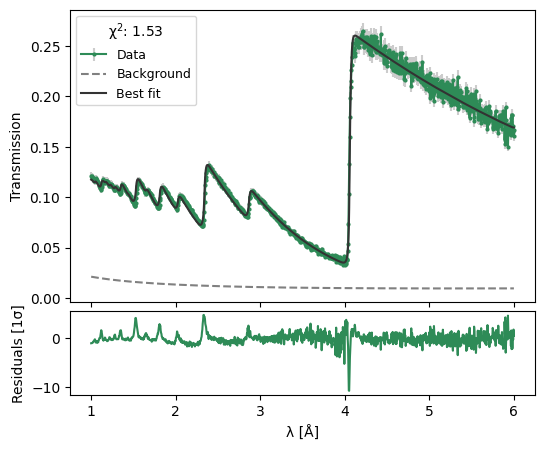

In [19]:
data = nbragg.Data.from_transmission("iron_powder.csv")                         # read data
xs = nbragg.CrossSection.from_material("Fe_sg229_Iron-alpha.ncmat")             # define sample
model = nbragg.TransmissionModel(xs,vary_background=True,vary_response=True)   # define model
result = model.fit(data)                                                        # perform fit
result.plot()                                                                   # plot results

# Load data
Use the `nbragg.Data` object to read bragg edge data

In [4]:
data = nbragg.Data.from_transmission("iron_powder.csv")

The data is accessible as a table using `nbragg.Data.table`. An automatic plot is generated using the `nbragg.Data.plot` method.

In [5]:
data.table

,wavelength,trans,err
0,0.501098,0.148315,0.004449
1,0.505493,0.147728,0.004432
2,0.509889,0.147725,0.004432
3,0.514284,0.148043,0.004441
4,0.518680,0.148369,0.004451
...,...,...,...
2156,9.977258,0.050633,0.001519
2157,9.982328,0.043011,0.001291
2158,9.986135,0.103448,0.003104
2159,9.991219,0.062500,0.001875


<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

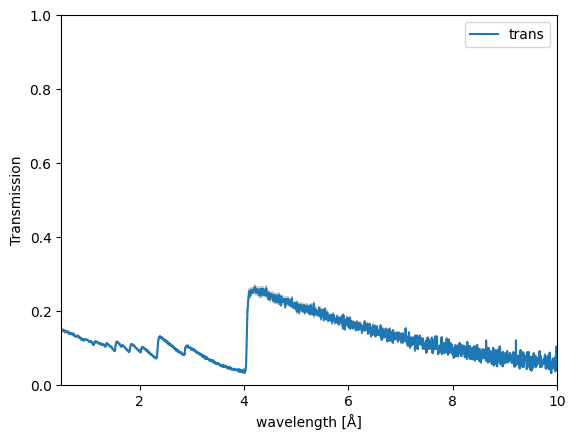

In [6]:
data.plot()

## Define samples
In this step the user defines the composition of the sample. You can choose from a variety of predefined crystalline materials from the `ncrystal` standard library, that is available under the `nbragg.materials` dictionary.

In [7]:
nbragg.materials["AgBr_sg225_SilverBromide.ncmat"]

{'name': 'SilverBromide',
 'filename': 'AgBr_sg225_SilverBromide.ncmat',
 'formula': 'AgBr',
 'space_group': 'sg225'}

Use the `nbragg.CrossSection.from_material` method to upload a single material from the standard library

In [8]:
gamma = nbragg.CrossSection.from_material(nbragg.materials["Fe_sg225_Iron-gamma.ncmat"])
alpha = nbragg.CrossSection.from_material(nbragg.materials["Fe_sg229_Iron-alpha.ncmat"])

You can also register new `.ncmat` files into the ncrystal library using the `nbragg.utils.register_material` and upload them in the same way.

In [9]:
nbragg.utils.register_material("Fe_sg229_Iron-alpha_LGS.ncmat")
alphaLGS = nbragg.CrossSection.from_material(nbragg.materials["Fe_sg229_Iron-alpha_LGS.ncmat"])

You can easily combine materials simply by adding them together. Check the ncrystal cfg_string that uses the phases keyword to define a multiphase material

In [10]:
xs = alpha + gamma

# or

xs = alpha*0.3 + gamma*0.7

In [11]:
xs.cfg_string

'phases<0.3*Fe_sg229_Iron-alpha.ncmat;temp=300.0K&0.7*Fe_sg225_Iron-gamma.ncmat;temp=300.0K>'

The cross section data can be accessed through `nbragg.CrossSection.table` and plotted using the `nbragg.CrossSection.plot` method

In [12]:
xs.table.columns = xs.weights.index.to_list() + ["total"]

In [13]:
xs.table

,Fe_sg229_Iron-alpha.ncmat,Fe_sg225_Iron-gamma.ncmat,total
wavelength,,,
1.00,12.295375,12.428597,12.387429
1.01,12.416289,12.511658,12.482177
1.02,12.417504,12.444321,12.435927
1.03,12.541076,12.209024,12.311080
1.04,12.666980,12.289154,12.405378
...,...,...,...
9.95,15.322926,15.548789,15.479157
9.96,15.337796,15.563801,15.494108
9.97,15.352663,15.578811,15.509056


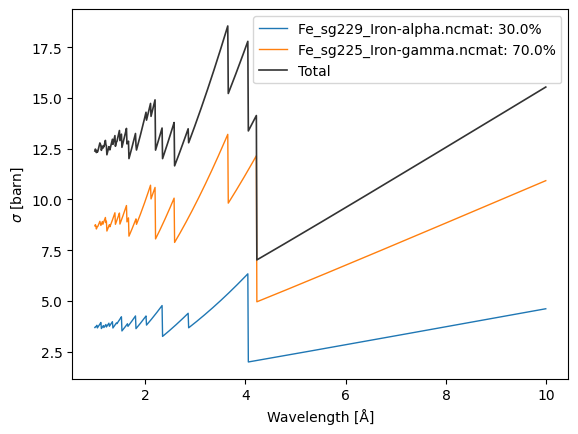

In [14]:
xs.plot();

# Define a transmission model
Next step is to define a model and adjust model parameters. The fit process in nbragg is based the super friendly package `lmfit`.

Defining a transmission model requires providing the `nbragg.CrossSection` object you created, as well as few flags in case you are interested in including non-default parameters to the model. In this example we define a model and request to vary background and response parameters.

In [15]:
model = nbragg.TransmissionModel(alpha,background="polynomial3",vary_background=True,vary_response=True)

In [16]:
model.params

name,value,initial value,min,max,vary
thickness,1.00000000,None,-inf,inf,True
norm,1.00000000,None,-inf,inf,True
α1,3.67000000,3.67,-inf,inf,True
β1,3.06000000,3.06,-inf,inf,True
b0,0.00000000,0.0,-inf,inf,True
b1,0.00000000,0.0,-inf,inf,True
b2,0.00000000,0.0,-inf,inf,True


In [17]:
result = model.fit(data,wlmin=1,wlmax=5)

/sammy/work/Programs/braggedgemodeling/bem/peak_profile.py:88: RuntimeWarning: divide by zero encountered in divide
  y = (alpha*sigma2+x)/(sqrt2*sigma)
/sammy/work/Programs/braggedgemodeling/bem/peak_profile.py:89: RuntimeWarning: divide by zero encountered in divide
  z = (beta*sigma2 - x)/(sqrt2*sigma)


array([<Axes: ylabel='Transmission'>,
       <Axes: xlabel='λ [Å]', ylabel='Residuals [1σ]'>], dtype=object)

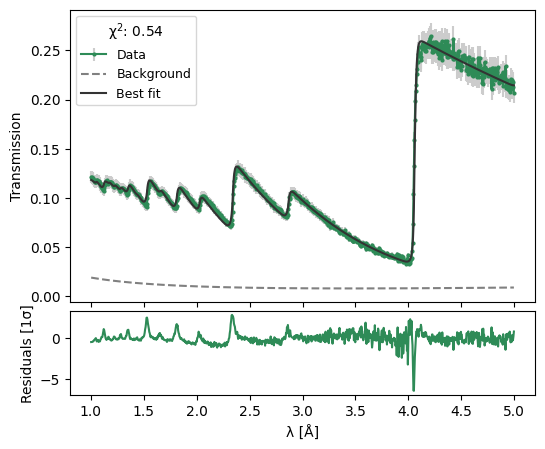

In [19]:
result.plot()

In [24]:
result

In [69]:
from urllib.request import urlopen, Request
import pandas as pd
import io

x4id = 13733002
req = Request(
        url=f'https://nds.iaea.org/exfor/x4get?DatasetID={x4id}&op=csv',
        data=None,
        headers={
            'User-Agent': 'Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
        }
    )
with urlopen(req) as f:
    df = pd.read_csv(io.StringIO(f.read().decode('utf-8')))
if 'EN (EV) 1.1' in list(df):
    x4_E, x4_xs = df['EN (EV) 1.1'].values, df['DATA (B) 0.1'].values
elif 'EN (MEV) 1.1' in list(df):
    x4_E, x4_xs = 1e6*df['EN (MEV) 1.1'].values, df['DATA (B) 0.1'].values

df = df[['EN (EV) 1.1',"DATA (B) 0.1",'DATA-ERR (B) 0.911']]
df.columns = ["energy", "data", "data_err"]

In [70]:
df.to_csv("Be_13733002.exfor.txt",sep=" ",header=False)

<Axes: xlabel='energy'>

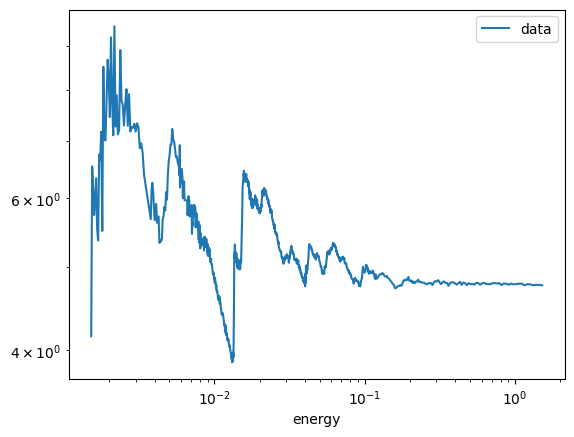

In [61]:
df.plot(x="energy",y="data",loglog=True)